In [2]:
import pandas as pd
import numpy as np

In [73]:
raw_data = pd.read_csv('/home/rohitb/projects/ml/Project/assets/OASIS-1/demographic_data/oasis_cross-sectional-5708aa0a98d82080.csv')
# raw_data=raw_data.drop(['ID','M/F','Hand','Educ','SES','MMSE','Delay'],axis=1)
raw_data=raw_data.drop(['ID','Delay'],axis=1)
raw_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105
4,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010


In [31]:
completed_data = raw_data.dropna()
testing_data = raw_data.dropna()
indices = np.random.choice(testing_data.index, size=int(0.4*len(testing_data['CDR'])), replace=False)

In [45]:
from sklearn.preprocessing import LabelEncoder
# Create label encoder objects
le_gender = LabelEncoder()
le_hand = LabelEncoder()

# Encode M/F column
testing_data['M/F'] = le_gender.fit_transform(testing_data['M/F'])
# Encode M/F column for completed_data
completed_data['M/F'] = le_gender.fit_transform(completed_data['M/F'])

# Encode Hand column 
testing_data['Hand'] = le_hand.fit_transform(testing_data['Hand'])
# Encode Hand column for completed_data
completed_data['Hand'] = le_hand.fit_transform(completed_data['Hand'])


 Here's a quick breakdown of which might be more correlated:

- Age: Highly likely to be correlated with CDR, as older age is a known risk factor for cognitive decline and dementia.
- eTIV (Estimated Total Intracranial Volume): Could have a weaker correlation, as brain volume is indirectly related to age and dementia, but not a direct measure of cognitive decline.
- nWBV (Normalized Whole Brain Volume): More relevant than eTIV, as it reflects the proportion of the brain remaining after accounting for atrophy, which is a hallmark of dementia.
- ASF (Atlas Scaling Factor): Might show some indirect correlation with brain size, but its relevance to cognitive decline could be lower.
- M/F (Gender): There are known differences in how dementia progresses between males and females, so it might have some correlation.
- Hand (Handedness): Likely to have little correlation with CDR.

Filling the CDR values with data imputation methods. In this case Multivariate Imputation by Chained-Equations (MICE) is used.

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

There will be a comparision done between:
- MICE with Linear Regression
- MICE with Random Forrest Regression
- MICE with Support Vector Regression

And the best one will be chosen

# MICE with Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

In [32]:
testing_data.loc[indices,'CDR'] = np.nan
testing_data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,NaN,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,NaN,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,NaN,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
411,F,R,70,1.0,4.0,29.0,NaN,1295,0.748,1.355
412,F,R,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,F,R,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


In [41]:
lr = LinearRegression()
imp = IterativeImputer(estimator=lr, verbose=2, max_iter=5, imputation_order='roman')


In [42]:
ImputedData = imp.fit_transform(testing_data)

[IterativeImputer] Completing matrix with shape (216, 10)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.02
[IterativeImputer] Change: 1.0151139527358266, scaled tolerance: 1.992 
[IterativeImputer] Early stopping criterion reached.


In [43]:
Imputed_data = pd.DataFrame(ImputedData)
Imputed_data.columns = raw_data.columns
Imputed_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,0.0,74.0,2.0,3.0,29.0,0.160708,1344.0,0.743,1.306
1,0.0,0.0,55.0,4.0,1.0,29.0,-0.053228,1147.0,0.810,1.531
2,0.0,0.0,73.0,4.0,3.0,27.0,0.373221,1454.0,0.708,1.207
3,1.0,0.0,74.0,5.0,2.0,30.0,0.000000,1636.0,0.689,1.073
4,0.0,0.0,52.0,3.0,2.0,30.0,0.000000,1321.0,0.827,1.329


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_lr = mean_squared_error(Imputed_data, completed_data)
print(f'Mean Squared Error (MSE): {mse_lr}')

mae_lr = mean_absolute_error(Imputed_data, completed_data)
print(f'Mean Absolute Error (MAE): {mae_lr}')

r_squared_lr = r2_score(Imputed_data, completed_data)
print(f'Coefficient of Determination (R-squared): {r_squared_lr}')

Mean Squared Error (MSE): 0.0020127767530290597
Mean Absolute Error (MAE): 0.006781183475183276
Coefficient of Determination (R-squared): 0.983118182684871


# MICE with Random Forest Regression

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
testing_data.loc[indices,'CDR'] = np.nan
testing_data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,74,2.0,3.0,29.0,NaN,1344,0.743,1.306
1,0,0,55,4.0,1.0,29.0,NaN,1147,0.810,1.531
2,0,0,73,4.0,3.0,27.0,NaN,1454,0.708,1.207
8,1,0,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,0,0,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
411,0,0,70,1.0,4.0,29.0,NaN,1295,0.748,1.355
412,0,0,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,0,0,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,1,0,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


In [50]:
rf = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=rf, verbose=2, max_iter=5, imputation_order='roman')

In [51]:
ImputedData = imp.fit_transform(testing_data)

[IterativeImputer] Completing matrix with shape (216, 10)
[IterativeImputer] Ending imputation round 1/5, elapsed time 1.82
[IterativeImputer] Change: 1.1323076923076922, scaled tolerance: 1.992 
[IterativeImputer] Early stopping criterion reached.


In [52]:
Imputed_data = pd.DataFrame(ImputedData)
Imputed_data.columns = raw_data.columns
Imputed_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,0.0,74.0,2.0,3.0,29.0,0.145,1344.0,0.743,1.306
1,0.0,0.0,55.0,4.0,1.0,29.0,0.040,1147.0,0.810,1.531
2,0.0,0.0,73.0,4.0,3.0,27.0,0.600,1454.0,0.708,1.207
3,1.0,0.0,74.0,5.0,2.0,30.0,0.000,1636.0,0.689,1.073
4,0.0,0.0,52.0,3.0,2.0,30.0,0.000,1321.0,0.827,1.329


In [54]:
mse_rf = mean_squared_error(Imputed_data, completed_data)
print(f'Mean Squared Error (MSE): {mse_rf}')

mae_rf = mean_absolute_error(Imputed_data, completed_data)
print(f'Mean Absolute Error (MAE): {mae_rf}')

r_squared_rf = r2_score(Imputed_data, completed_data)
print(f'Coefficient of Determination (R-squared): {r_squared_rf}')

Mean Squared Error (MSE): 0.001906921296296296
Mean Absolute Error (MAE): 0.006458333333333332
Coefficient of Determination (R-squared): 0.984146367866272


# MICE with Support Vector Regression

In [55]:
from sklearn.svm import SVR

In [56]:
testing_data.loc[indices,'CDR'] = np.nan
testing_data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,74,2.0,3.0,29.0,NaN,1344,0.743,1.306
1,0,0,55,4.0,1.0,29.0,NaN,1147,0.810,1.531
2,0,0,73,4.0,3.0,27.0,NaN,1454,0.708,1.207
8,1,0,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,0,0,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
411,0,0,70,1.0,4.0,29.0,NaN,1295,0.748,1.355
412,0,0,73,3.0,2.0,23.0,0.5,1536,0.730,1.142
413,0,0,61,2.0,4.0,28.0,0.0,1354,0.825,1.297
414,1,0,61,5.0,2.0,30.0,0.0,1637,0.780,1.072


In [57]:
svm = SVR()
imp = IterativeImputer(estimator=svm, verbose=2, max_iter=5, imputation_order='roman')

In [58]:
ImputedData = imp.fit_transform(testing_data)

[IterativeImputer] Completing matrix with shape (216, 10)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.05
[IterativeImputer] Change: 0.15893876200184073, scaled tolerance: 1.992 
[IterativeImputer] Early stopping criterion reached.


In [59]:
Imputed_data = pd.DataFrame(ImputedData)
Imputed_data.columns = raw_data.columns
Imputed_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,0.0,74.0,2.0,3.0,29.0,0.100341,1344.0,0.743,1.306
1,0.0,0.0,55.0,4.0,1.0,29.0,0.100392,1147.0,0.810,1.531
2,0.0,0.0,73.0,4.0,3.0,27.0,0.100441,1454.0,0.708,1.207
3,1.0,0.0,74.0,5.0,2.0,30.0,0.000000,1636.0,0.689,1.073
4,0.0,0.0,52.0,3.0,2.0,30.0,0.000000,1321.0,0.827,1.329


In [60]:
mse_svr = mean_squared_error(Imputed_data, completed_data)
print(f'Mean Squared Error (MSE): {mse_svr}')

mae_svr = mean_absolute_error(Imputed_data, completed_data)
print(f'Mean Absolute Error (MAE): {mae_svr}')

r_squared_svr = r2_score(Imputed_data, completed_data)
print(f'Coefficient of Determination (R-squared): {r_squared_svr}')

Mean Squared Error (MSE): 0.0074928604628533724
Mean Absolute Error (MAE): 0.01164430513394028
Coefficient of Determination (R-squared): 0.914331964205639


# Comparision between different imputation models

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

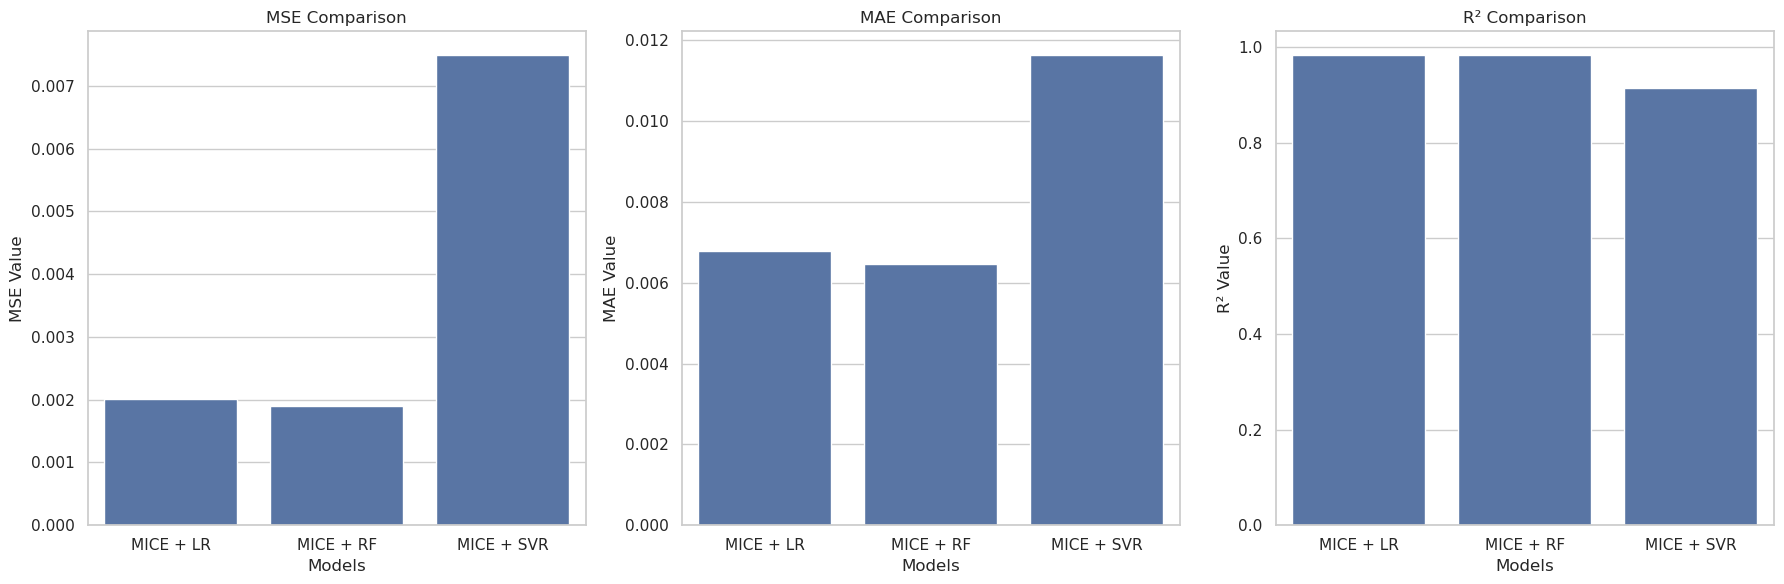

In [62]:
data = {
    'Model': ['MICE + LR', 'MICE + RF', 'MICE + SVR'],
    'MSE': [mse_lr,mse_rf,mse_svr],  # Replace with your actual MSE values
    'MAE': [mae_lr,mae_rf,mae_svr],  # Replace with your actual MAE values
    'R²': [r_squared_lr,r_squared_rf,r_squared_svr]    # Replace with your actual R² values
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for MSE
sns.barplot(x='Model', y='MSE', data=df, ax=axes[0])
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('MSE Value')
axes[0].set_xlabel('Models')

# Bar plot for MAE
sns.barplot(x='Model', y='MAE', data=df, ax=axes[1])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE Value')
axes[1].set_xlabel('Models')

# Bar plot for R²
sns.barplot(x='Model', y='R²', data=df, ax=axes[2])
axes[2].set_title('R² Comparison')
axes[2].set_ylabel('R² Value')
axes[2].set_xlabel('Models')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


Thus MICE+RF seems to give the best result of data imputation and thus will be used to fill the NAN values

In [66]:
raw_data = pd.read_csv('/home/rohitb/projects/ml/Project/assets/OASIS-1/demographic_data/oasis_cross-sectional-5708aa0a98d82080.csv')
to_impute_data=raw_data.drop(['ID','Delay'],axis=1)
# Create label encoders for M/F and Hand columns
le_gender = LabelEncoder()
le_hand = LabelEncoder()

# Fit and transform the M/F column
to_impute_data['M/F'] = le_gender.fit_transform(to_impute_data['M/F'])

# Fit and transform the Hand column 
to_impute_data['Hand'] = le_hand.fit_transform(to_impute_data['Hand'])


to_impute_data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,0,0,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,0,0,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,1,0,28,NaN,NaN,NaN,NaN,1588,0.803,1.105
4,1,0,18,NaN,NaN,NaN,NaN,1737,0.848,1.010
...,...,...,...,...,...,...,...,...,...,...
431,1,0,20,NaN,NaN,NaN,NaN,1469,0.847,1.195
432,1,0,22,NaN,NaN,NaN,NaN,1684,0.790,1.042
433,1,0,22,NaN,NaN,NaN,NaN,1580,0.856,1.111
434,0,0,20,NaN,NaN,NaN,NaN,1262,0.861,1.390


In [67]:
lr = RandomForestRegressor(n_estimators=100)
imp = IterativeImputer(estimator=rf, verbose=2, max_iter=5, imputation_order='roman')

In [68]:
ImputedData = imp.fit_transform(to_impute_data)

[IterativeImputer] Completing matrix with shape (436, 10)
[IterativeImputer] Ending imputation round 1/5, elapsed time 3.57
[IterativeImputer] Change: 7.430740740740738, scaled tolerance: 1.992 
[IterativeImputer] Ending imputation round 2/5, elapsed time 7.07
[IterativeImputer] Change: 3.615, scaled tolerance: 1.992 
[IterativeImputer] Ending imputation round 3/5, elapsed time 10.54
[IterativeImputer] Change: 3.9649999999999994, scaled tolerance: 1.992 
[IterativeImputer] Ending imputation round 4/5, elapsed time 12.51
[IterativeImputer] Change: 3.444999999999997, scaled tolerance: 1.992 
[IterativeImputer] Ending imputation round 5/5, elapsed time 14.54
[IterativeImputer] Change: 2.445000000000001, scaled tolerance: 1.992 


/usr/lib/python3/dist-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [74]:
Imputed_data = pd.DataFrame(ImputedData)
Imputed_data.columns = to_impute_data.columns
Imputed_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,0.0,74.0,2.00,3.00,29.00,0.000,1344.0,0.743,1.306
1,0.0,0.0,55.0,4.00,1.00,29.00,0.000,1147.0,0.810,1.531
2,0.0,0.0,73.0,4.00,3.00,27.00,0.500,1454.0,0.708,1.207
3,1.0,0.0,28.0,3.15,3.00,22.10,0.545,1588.0,0.803,1.105
4,1.0,0.0,18.0,2.74,3.07,21.91,0.565,1737.0,0.848,1.010


In [75]:
def round_to_half(value):
    return round(value * 2) / 2

Imputed_data['CDR'] = Imputed_data['CDR'].apply(round_to_half)


In [76]:
Imputed_data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,0.0,74.0,2.00,3.00,29.00,0.0,1344.0,0.743,1.306
1,0.0,0.0,55.0,4.00,1.00,29.00,0.0,1147.0,0.810,1.531
2,0.0,0.0,73.0,4.00,3.00,27.00,0.5,1454.0,0.708,1.207
3,1.0,0.0,28.0,3.15,3.00,22.10,0.5,1588.0,0.803,1.105
4,1.0,0.0,18.0,2.74,3.07,21.91,0.5,1737.0,0.848,1.010


In [77]:
Imputed_data.to_csv('./oasis_cleaned.csv')